<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Neural_Network_From_Scratch_using_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Neural Net from Scratch using Numpy

So I have been working with neural networks for quite some time now, but I always felt I had a knowledge gap in terms of my understanding of Neural Networks and Backpropogation. This gave me some major Imposter Syndrome issues over time.


So this time I decided to go all the way through and learn the maths behind the algorithms and implement a rudimentry form of neural network, which can make useful predictions.

I know this is not even close to perfect and I welcome any suggestions or feedback to improve upon it.

### Theory

I will try to document as much theory I can, but i suggest going through below  Lectures and Notes to get a good ideas into the maths going on behind the algo.

<ul>
    <li><b><a href='https://www.youtube.com/watch?v=MfIjxPh6Pys'>Introduction to Neural Networks: </a></b></li>
    <li><b><a href='https://www.youtube.com/watch?v=zUazLXZZA2U&t=1872s'>Backpropogation: </a></b></li>
    <li><b><a href='http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf'>Deep Learning Notes</a></b></li>
</ul>

In [1]:
# Load libraries
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
# Loading our MNIST dataset
data = load_digits()
X = data['data']
y = data['target']

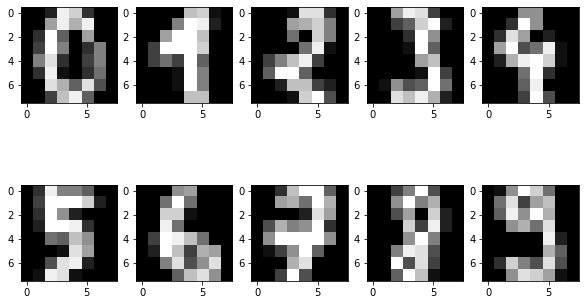

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,6))
for i in range(10):
    img = np.reshape(X[y == i][5],(8,8))
    ax[int(i/5)][i%5].imshow(img, cmap='gray')

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X/16, y, test_size=0.3)

In [5]:
# The class Layer, uniquely defines the attributes and functionalities of a layer e.g. size, activation function, weights etc.
class Layer:
    # Initializes the basic attributes of a single layer
    def __init__(self, size, index, activation='sigmoid'):
        self.size = size # defines the number of stacked neurons in the layer
        self.activation_func = activation # defines the activation function that each neuron in the layer uses
        self.layer_index = index # defines the location of layer in the network
        self.a = 0 # defines the output of the layer after running through activation
        self.z = 0 # defines the input of layer to the activation function
        
    # Weight initialization is very important or the we might see vanishing/exploding gradient problem
    # We use Glroot Initialization technique to intialize our weights and biases
    def init_weight(self, input_shape, output_shape):
        mean = 0
        std = np.sqrt(2/(input_shape + output_shape))
        self.weights = np.float32(np.random.uniform(-std, std, (output_shape, input_shape)))
        self.bias = np.float32(np.random.uniform(-std, std, (output_shape,1)))
    
    # return the output of layer after running the input through selected activation function
    def activation(self, inputs):
        self.z = np.dot(self.weights,inputs) + self.bias
        self.a = 1/(1 + np.exp(-self.z))
        return self.a
    
    # provides the derivative of activation function for the current output of the layer
    def activation_grad(self):
        return self.a * (1 - self.a)       

In [6]:
# Class Neural Network, defines multiple layers and runs forwad and back propogation to train the network.
class NeuralNetwork:
    
    # defines the shape of Network and initializes layers
    def __init__(self, shape):
        self.shape = shape
        self.layers = list()
        self.log_loss_hist = list()
        j = 0
        for i in shape:
            self.layers.append(Layer(i,j))
            j = j + 1
        
    # Initializes the weights and biases of our network for each layer
    def initialize(self, X, y):
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].init_weight(X.shape[1], self.layers[i].size)
            else:
                self.layers[i].init_weight(self.layers[i-1].size, self.layers[i].size)
       
    # performs forward propogation
    def forward_propogation(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
    # calculates log logs and return the result
    def loss(self, outputs, y):
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        outputs_lb = lb.transform(outputs)
        loss = log_loss(y_lb, outputs_lb)
        return loss
    
    # Performs the most critical, Backpropogation to calculate delta values for each layer
    def backpropogate(self, X, y):
        delta = list()
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = (self.layers[-1].z - y.T)
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].activation_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].a.T)/len(y)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)/len(y)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)/len(y)
        return (delta_w, delta_b)
        
    # Uses the delta values to update weights and biases
    def update_weights_bias(self, delta_w, delta_b, lr):
        #print(self.layers[0].bias.shape)
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - (lr*delta_w[i])
            layer.bias = layer.bias - (lr*delta_b[i]) 
    
    # Used to orchestrate the training of network, given a certain epoch and learning rate
    def train(self, X, y, epochs, batch_size, lr):
        self.initialize(X, y)
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        y_lb = lb.fit_transform(y)
        for i in range(epochs):
            low = 0
            high = low + batch_size
            self.log_loss_hist.append(self.loss(np.argmax(self.predict(X), axis=0), y))
            while(low < X.shape[0]):
                X_bat = X[low:high,:]
                y_bat = y_lb[low:high]
                self.forward_propogation(X_bat)
                outputs = self.layers[-1].a
                delta_w, delta_b = self.backpropogate(X_bat, y_bat)
                self.update_weights_bias(delta_w, delta_b, lr)
                low = high
                if (low + batch_size) > X.shape[0]:
                    high = X.shape[0]
                else:
                    high = low + batch_size

    # Runs the input through the network and returns
    def predict(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
        return a

In [7]:
# Define the model and its architecture
model = NeuralNetwork((64,32,16,10))

In [8]:
# Train our model using the hyper-parameters
model.train(X_train, y_train, 1000, 64, 0.1)

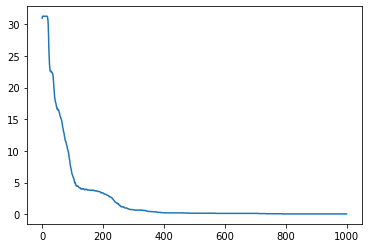

In [9]:
# Plot the log loss over epochs
sns.lineplot(x=list(range(len(model.log_loss_hist))), y=model.log_loss_hist)

In [10]:
# Make the prediction on test data and measure performance
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=0)
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred)*100,2)}")

Accuracy Score: 98.15


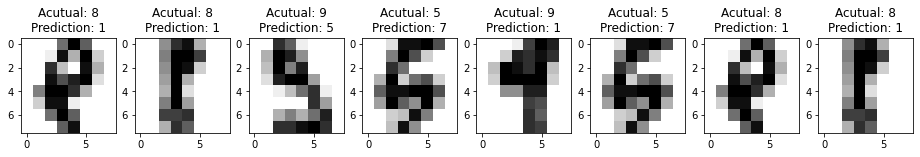

In [11]:
# Plot the wrongly predicted images, to get an idea of mistakes model is making
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(16,2))
wrongs = y_pred != y_test
samp = X_test[wrongs]
y_samp_true = y_test[wrongs]
y_samp_pred = y_pred[wrongs]
n = len(samp)
for i in range(8):
    idx = np.random.randint(0, n)
    img = np.reshape(samp[idx]*16, (8,8))
    ax[i].imshow(img, cmap='gray_r')
    ax[i].set_title(f"Acutual: {y_samp_true[idx]}\nPrediction: {y_samp_pred[idx]}")

# Conclusion

### I always thought that building something like this, was perhaps to much for me, until.... I built it.

### Thanks for Reading